## Train and explain a model

Note that this is a small sample of the whole data for demonstration purpose.

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/geoshapley/refs/heads/main/data/seattle_sample_1k.csv")

In [6]:
data = gpd.GeoDataFrame(
    data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

data


,Unnamed: 0,bathrooms,sqft_living,sqft_lot,grade,condition,waterfront,view,age,UTM_X,UTM_Y,log_price,geometry
0,0,3.00,2660,4600,8,3,0,0,109,552217.557035,5.274945e+06,6.091315,POINT (552217.557 5274944.781)
1,1,2.25,2530,8736,7,4,0,0,57,565692.484331,5.272758e+06,5.790988,POINT (565692.484 5272758.059)
2,2,2.00,1390,13464,7,4,0,0,28,562451.661509,5.245291e+06,5.315130,POINT (562451.662 5245291.268)
3,3,1.00,940,4264,7,5,0,0,66,546816.935618,5.264407e+06,5.619093,POINT (546816.936 5264406.872)
4,4,2.25,2070,7225,8,3,0,0,36,564343.195352,5.244978e+06,5.477121,POINT (564343.195 5244978.22)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1.00,790,13170,6,3,0,0,68,548381.646974,5.266342e+06,5.447158,POINT (548381.647 5266342.401)
996,996,2.50,2000,5390,7,3,0,0,12,565755.572522,5.247006e+06,5.453318,POINT (565755.573 5247005.588)
997,997,1.75,2160,5760,8,4,0,0,61,545835.661307,5.264755e+06,5.826075,POINT (545835.661 5264754.754)
998,998,3.00,1950,1983,9,3,0,0,6,559976.813626,5.273019e+06,5.894870,POINT (559976.814 5273018.798)


In [7]:
y = data.log_price

X_coords = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition',
                 'waterfront', 'view', 'age','UTM_X', 'UTM_Y']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_coords, y, random_state=1)

## Model training by AutoML

In [9]:
from flaml import AutoML

settings = {
    "time_budget": 20,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": 'auto',  # list of ML learners; 'auto' means try all
    "task": 'regression',  # task type, can also be classification   
    "eval_method": 'cv', #enable cross-validation
    "n_splits": 5, #5-fold cross validation
    "verbose": 3
}

automl = AutoML()
automl.fit(X_train, y_train,  **settings)

[flaml.automl.logger: 12-23 20:42:37] {1752} INFO - task = regression
[flaml.automl.logger: 12-23 20:42:37] {1763} INFO - Evaluation method: cv
[flaml.automl.logger: 12-23 20:42:37] {1862} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 12-23 20:42:37] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 12-23 20:42:37] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-23 20:42:38] {2417} INFO - Estimated sufficient time budget=1456s. Estimated necessary time budget=10s.
[flaml.automl.logger: 12-23 20:42:38] {2466} INFO -  at 0.2s,	estimator lgbm's best error=0.6609,	best estimator lgbm's best error=0.6609
[flaml.automl.logger: 12-23 20:42:38] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-23 20:42:38] {2466} INFO -  at 0.3s,	estimator lgbm's best error=0.6609,	best estimator lgbm's best error=0.6609
[flaml.automl.logger: 12-23 20:42:38] {2282} 

In [10]:
auto_pred = automl.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test, auto_pred)

0.8180801134719025

In [11]:
automl.model.estimator

,boosting_type,'gbdt'
,num_leaves,4
,max_depth,-1
,learning_rate,np.float64(0....5013601703466)
,n_estimators,50
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,4


In [12]:

from geoshapley import GeoShapleyExplainer

In [13]:
import shap

#It is suggested to use a small representative samples as background
#This can be randomly chosen, or as shown here, using k-means

background_X = shap.kmeans(X_coords,k=10).data

In [14]:
%%time
automl_explainer = GeoShapleyExplainer(automl.model.estimator.predict, background_X)

rslt = automl_explainer.explain(X_coords, n_jobs=-1)

e:\geoshapley\venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: total: 5.78 s
Wall time: 26.8 s


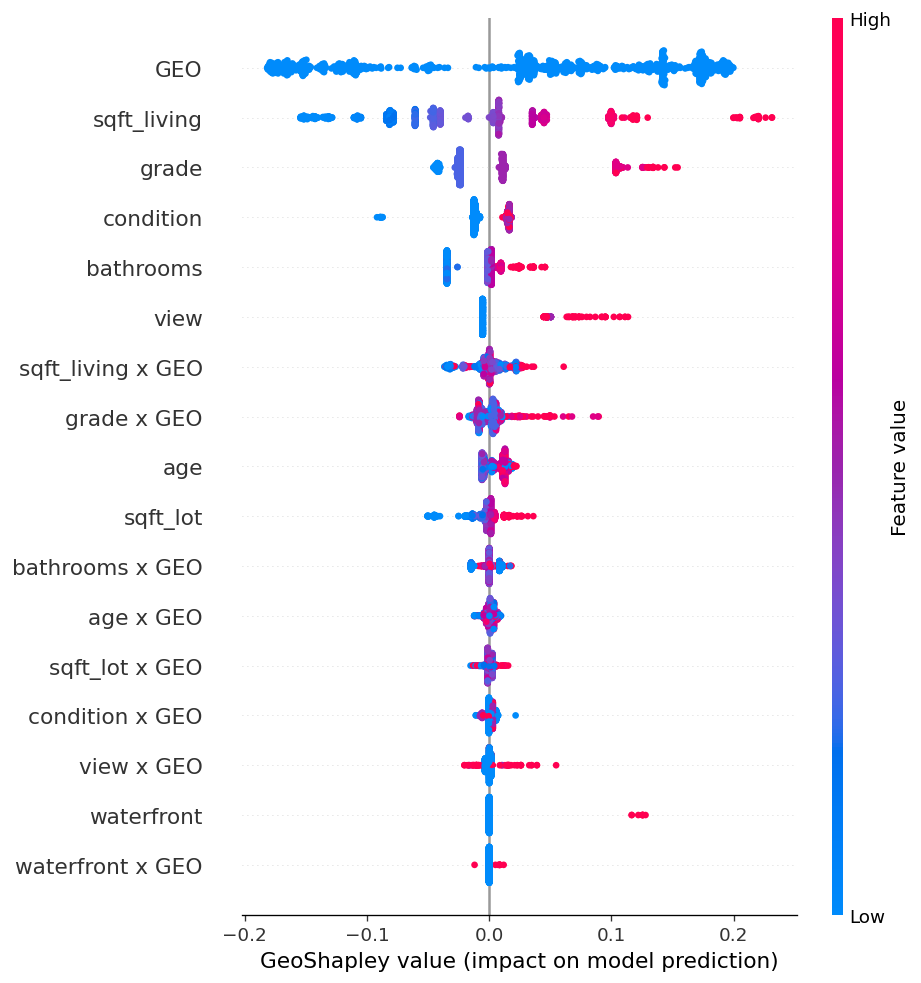

In [15]:
rslt.summary_plot(dpi=120)

In [16]:
rslt.summary_statistics()

,min,25%,50%,75%,max,mean,std,abs. mean
GEO,-1.816542e-01,-1.096464e-01,4.828853e-02,1.420398e-01,0.199780,0.028995,0.123951,0.114176
sqft_living,-1.543730e-01,-6.067781e-02,-1.709303e-02,3.518610e-02,0.231324,-0.013018,0.077465,0.061724
grade,-4.554464e-02,-2.483552e-02,-2.354549e-02,1.118891e-02,0.154160,0.003362,0.048845,0.036326
condition,-9.177161e-02,-1.241436e-02,-1.132447e-02,1.502961e-02,0.018359,-0.002149,0.015892,0.013994
bathrooms,-3.458612e-02,-3.458610e-02,-1.198935e-03,1.798406e-03,0.045628,-0.006934,0.018530,0.013028
view,-5.496782e-03,-5.496769e-03,-5.496768e-03,-5.496763e-03,0.113602,0.000836,0.020418,0.010726
sqft_living x GEO,-3.671699e-02,-4.118175e-03,1.824494e-04,5.640223e-03,0.060929,0.000772,0.012455,0.008216
grade x GEO,-2.431420e-02,-7.052123e-03,2.249725e-03,5.326186e-03,0.089589,0.001081,0.011392,0.007546
age,-6.060963e-03,-4.592914e-03,1.328260e-03,1.124216e-02,0.022152,0.002949,0.008423,0.007527
sqft_lot,-5.036530e-02,-3.332859e-03,-2.209413e-03,1.349194e-03,0.036116,-0.002721,0.011173,0.006475


In [17]:
rslt.check_additivity()

Components add up to model prediction:  True


### Location invariant primary effects

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 30% (3 of 10) |#######                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 40% (4 of 10) |##########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (9 of 10) |######################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 40% (4 of 10) |##########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (8 of 10) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                        

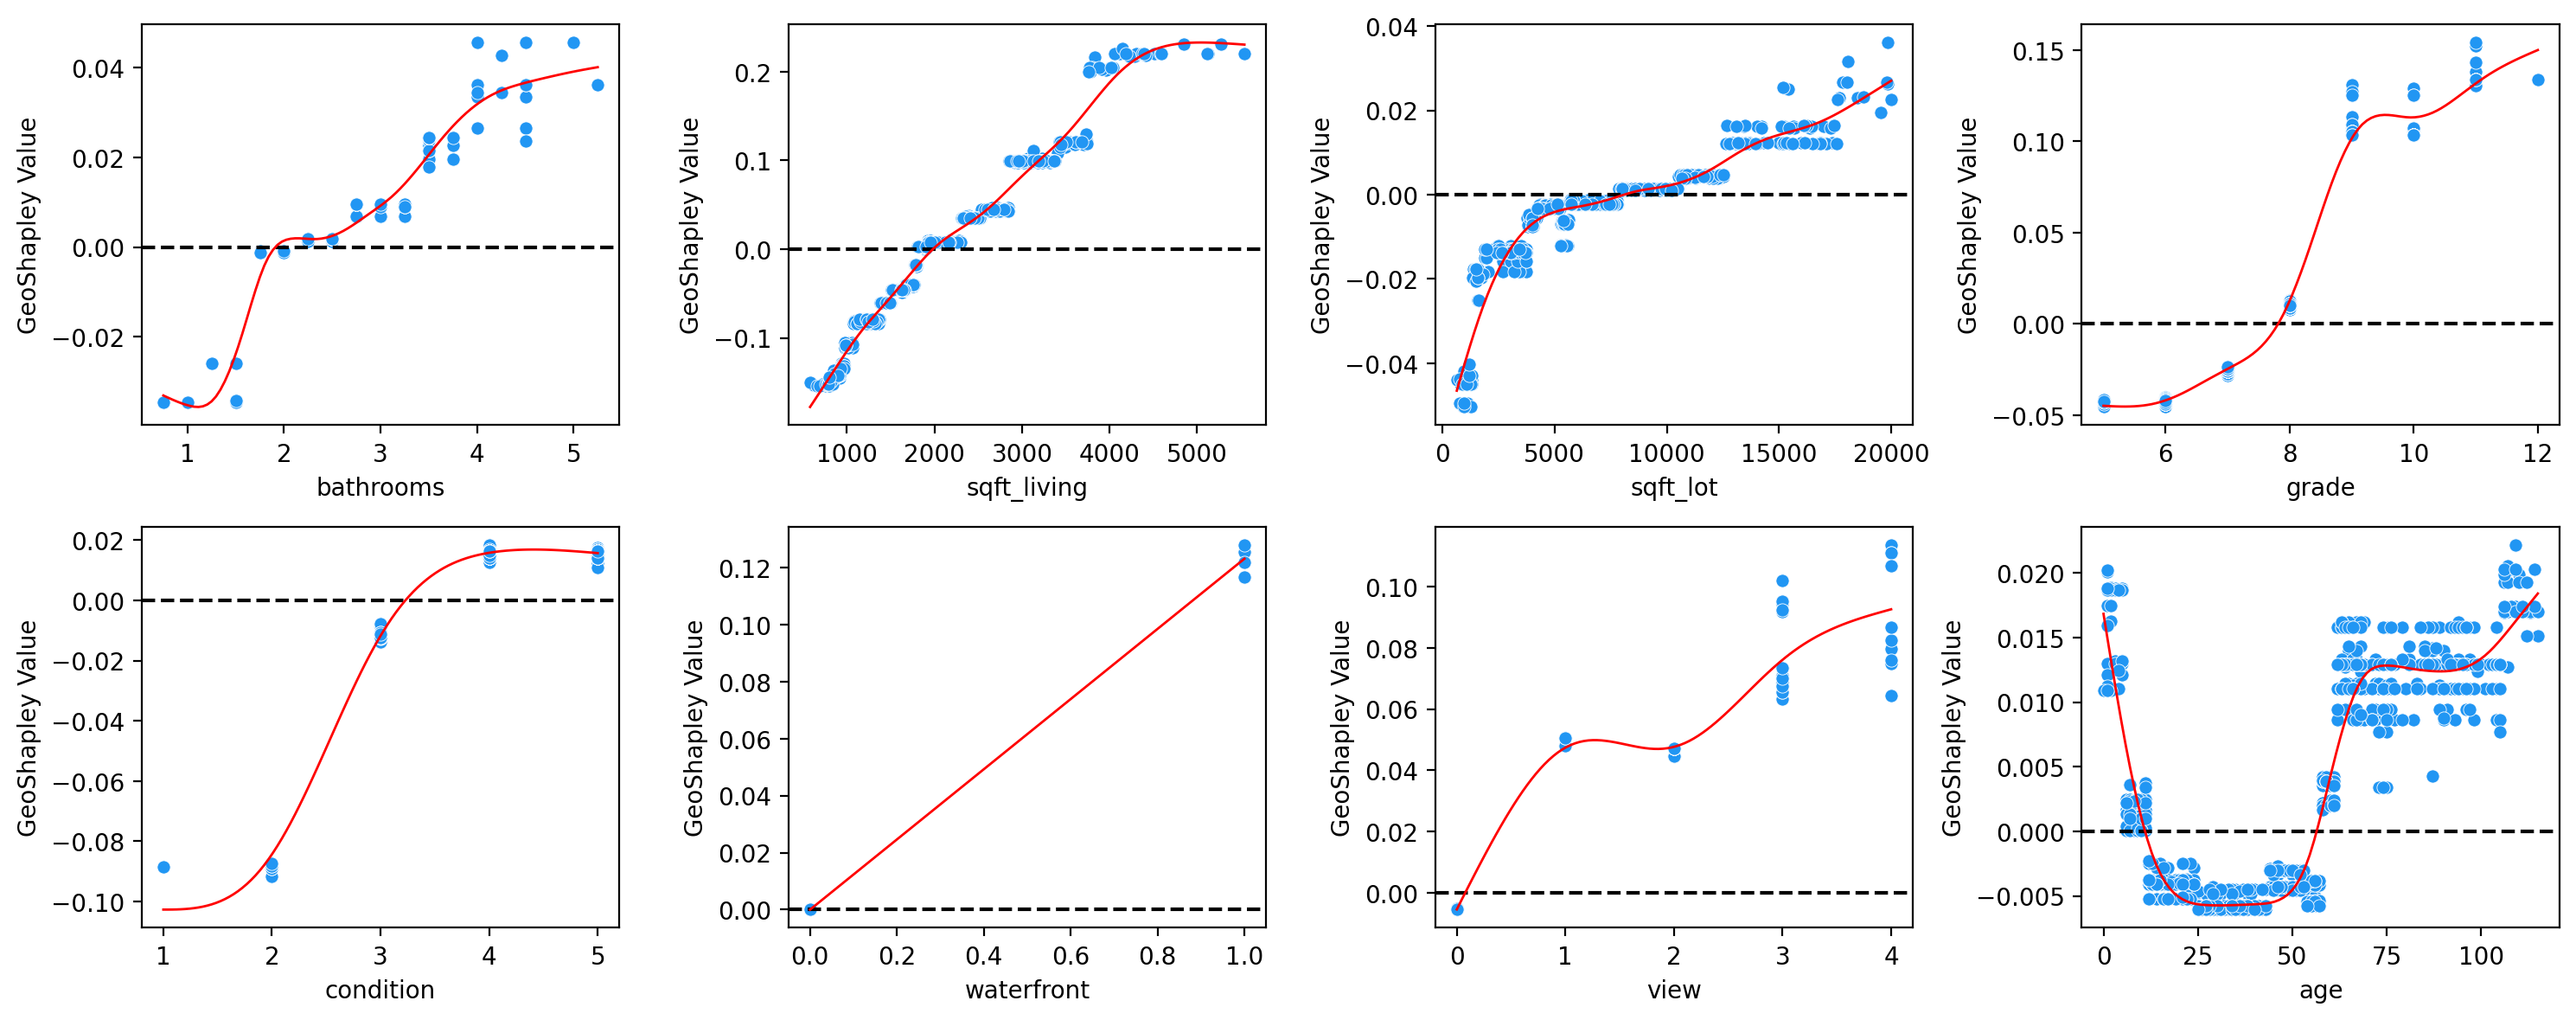

In [18]:
rslt.partial_dependence_plots(figsize=(15,6),max_cols=4,gam_curve=True,s=30)

In [19]:
coords = data[['UTM_X','UTM_Y']].values

## Calculate Spatially Varying Coefficients from GeoShapley values

SVCs are smoothed using GWR.

In [20]:
#if include_primary is set to True, the spatially varying effects will contain the above non-linear effects.
svc = rslt.get_svc(col = [0,1,2,3,4,5,6,7], coef_type="gwr", include_primary=False, coords=coords)

Please install mgwr package (e.g., pip install mgwr)


UnboundLocalError: cannot access local variable 'mgwr' where it is not associated with a value

In [21]:
X_coords.columns

Index(['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition',
       'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y'],
      dtype='object')

In [23]:
import contextily as cx

### Intrinsic location effect

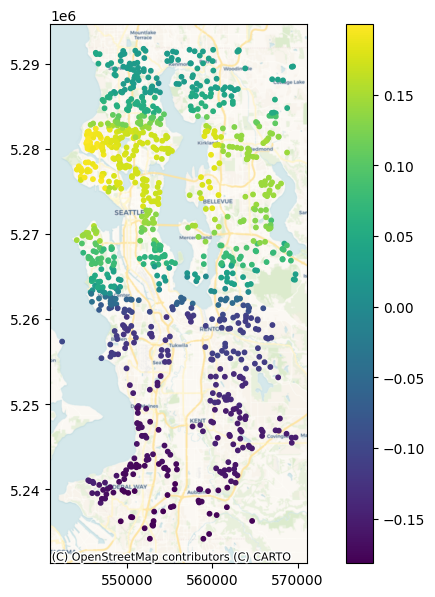

In [24]:
fig, ax = plt.subplots(1, 1,figsize=(10,7),dpi=100)

data.plot(ax=ax,column=rslt.geo,
                  s=10,figsize=(10,10),legend=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=data.crs,zoom=11)

### Spatially varying coefficient for sqft_living (after removing global primary effect)

NameError: name 'svc' is not defined

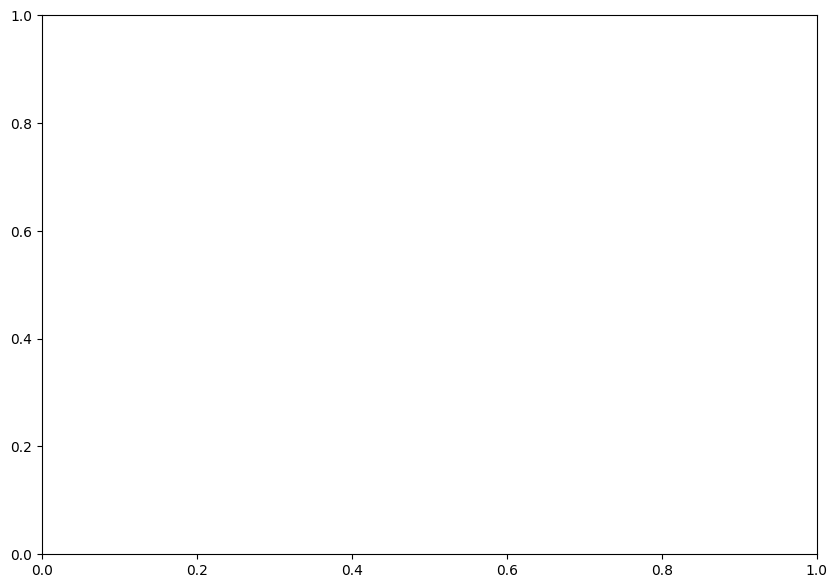

In [25]:
fig, ax = plt.subplots(1, 1,figsize=(10,7),dpi=100)

data.plot(ax=ax,column=svc[:,1],
                  s=10,figsize=(10,10),legend=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=data.crs,zoom=11)

### Spatially varying coefficient for age (after removing global primary effect)

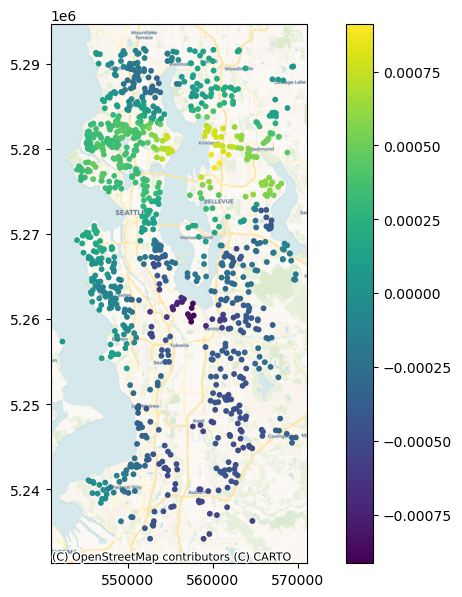

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(10,7),dpi=100)

data.plot(ax=ax,column=svc[:,7],
                  s=10,figsize=(10,10),legend=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=data.crs,zoom=11)

### Spatially varying coefficient for waterfront (after removing global primary effect)

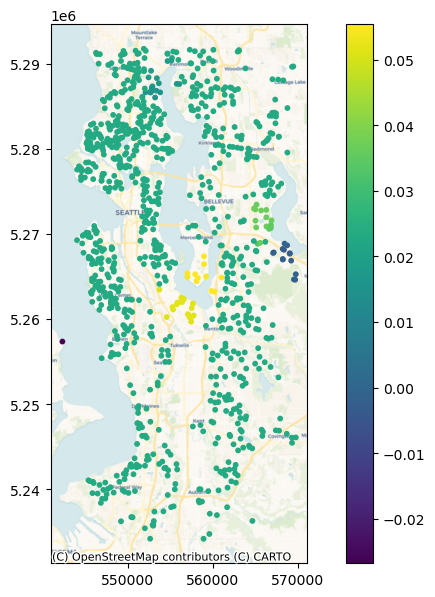

In [23]:
fig, ax = plt.subplots(1, 1,figsize=(10,7),dpi=100)

data.plot(ax=ax,column=svc[:,5],
                  s=10,figsize=(10,10),legend=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=data.crs,zoom=11)